# APA Laboratori 6 - MLP and the RBF                

In [1]:
# uncomment to install missing libraries
# install.packages('nnet')
# install.packages('caret')
# install.packages('cclust')

In [2]:
options(repr.plot.width=6, repr.plot.height=6)

In [3]:
library(MASS)
library(nnet)
set.seed (4567)

## Multilayer Perceptron Example 1: Admission into graduate school data

Suppose we are interested in how variables, such as 

GRE (Graduate Record Exam scores)

GPA (Grade Point Average) and 

rank (prestige of the undergraduate institution)

affect admission into a graduate school.

 The target variable, admit/don't admit, is a binary variable, which we want to characterize
and, if possible, to predict (a model)

In [4]:
Admis <- read.csv("Admissions.csv")

 view the first few rows of the data

In [5]:
head(Admis)

admit,gre,gpa,rank
0,380,3.61,3
1,660,3.67,3
1,800,4.00,1
1,640,3.19,4
0,520,2.93,4
1,760,3.00,2


 We will treat all the variables gre and gpa as continuous. 

The variable rank takes on the values 1 through 4, so we can fairly treat it as numerical
(although, in rigour, it is ordinal)

In [6]:
Admis$admit <- factor(Admis$admit, labels=c("No","Yes"))

summary(Admis)

N <- nrow(Admis)

 admit          gre             gpa             rank      
 No :273   Min.   :220.0   Min.   :2.260   Min.   :1.000  
 Yes:127   1st Qu.:520.0   1st Qu.:3.130   1st Qu.:2.000  
           Median :580.0   Median :3.395   Median :2.000  
           Mean   :587.7   Mean   :3.390   Mean   :2.485  
           3rd Qu.:660.0   3rd Qu.:3.670   3rd Qu.:3.000  
           Max.   :800.0   Max.   :4.000   Max.   :4.000  

 We first split the available data into learning and test sets, selecting randomly 2/3 and 1/3 of the data
 We do this for a honest estimation of prediction performance

In [7]:
set.seed(43)

learn <- sample(1:N, round(2*N/3))

nlearn <- length(learn)
ntest <- N - nlearn

We start using logistic regression (a linear classifier)

In [8]:
model.logreg <- glm (admit~., data=Admis[learn,], family=binomial)

summary(model.logreg)


Call:
glm(formula = admit ~ ., family = binomial, data = Admis[learn, 
    ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6190  -0.9154  -0.6441   1.1249   2.1551  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.879084   1.403346  -2.764 0.005707 ** 
gre          0.001468   0.001307   1.124 0.261161    
gpa          1.074822   0.396957   2.708 0.006776 ** 
rank        -0.566394   0.152750  -3.708 0.000209 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 341.27  on 266  degrees of freedom
Residual deviance: 312.22  on 263  degrees of freedom
AIC: 320.22

Number of Fisher Scoring iterations: 3


Simplify the model using the AIC

In [9]:
model.logreg2 <- step(model.logreg)

Start:  AIC=320.22
admit ~ gre + gpa + rank

       Df Deviance    AIC
- gre   1   313.49 319.49
<none>      312.22 320.22
- gpa   1   319.91 325.91
- rank  1   327.04 333.04

Step:  AIC=319.49
admit ~ gpa + rank

       Df Deviance    AIC
<none>      313.49 319.49
- gpa   1   324.69 328.69
- rank  1   329.40 333.40


 The new model has one variable less and the error (residual deviance) is virtually the same (313.5 vs 312.2)

 Interpretation of the coefficients

In [10]:
exp(model.logreg2$coefficients)

(Intercept)         gpa        rank 
 0.03153714  3.38896809  0.55901887

Calculation of apparent error in the training set (learn)

In [11]:
glfpred=NULL
glfpred[model.logreg2$fitted.values<0.5]=0
glfpred[model.logreg2$fitted.values>=0.5]=1
table(Admis$admit[learn],glfpred)
error_rate.learn <- 100*(1-sum(diag(table(Admis$admit[learn],glfpred)))/nlearn)
error_rate.learn

     glfpred
        0   1
  No  163  14
  Yes  63  27

[1] 28.83895

 we get a learning error which is quite high (28.84%)

 Estimation of prediction error using the test set

In [12]:
glft = predict(model.logreg2, newdata=Admis[-learn,]) 
pt = 1/(1+exp(-glft))
glfpredt = NULL
glfpredt[pt<0.5]=0
glfpredt[pt>=0.5]=1
table(Admis$admit[-learn],glfpredt)
error_rate.test <- 100*(1-sum(diag(table(Admis$admit[-learn],glfpredt)))/ntest)
error_rate.test

     glfpredt
       0  1
  No  87  9
  Yes 27 10

[1] 27.06767

 we get a prediction error of 27.07%

 Now we switch to non-linear modelling with a MLP

 The nnet() function is quite powerful and very reliable from the optimization
 point fo view. From the computational point of view, it has two drawbacks:

1. it does not have a built-in mechanism for multiple runs or cross-validation
2. it only admits networks of one hidden layer (of size 'size')

Please have a look at nnet before going any further

In [13]:
?nnet

The basic parameters are 'size' and 'decay' (the regularization constant, lambda)
 As usual, R detects it is a classification problem because 'admit' is a factor
 It buils a MLP with one output neuron (just two classes), with the logistic function
and uses the cross-entropy as error function

 Let's start by scaling of inputs, this is important to avoid network 'stagnation' (premature convergence)

In [14]:
Admis$gpa <- scale(Admis$gpa)
Admis$gre <- scale(Admis$gre)
Admis$rank <- scale(Admis$rank)
head(Admis)

admit,gre,gpa,rank
No,-1.7980110,0.5783479,0.5452850
Yes,0.6258844,0.7360075,0.5452850
Yes,1.8378321,1.6031352,-1.5723268
Yes,0.4527490,-0.5252692,1.6040909
No,-0.5860633,-1.2084607,1.6040909
Yes,1.4915613,-1.0245245,-0.5135209


To illustrate the first results, we just fit a MLP with 2 hidden neurons

In [15]:
model.nnet <- nnet(admit ~., data = Admis, subset=learn, size=2, maxit=200, decay=0)

# weights:  11
initial  value 185.455554 
iter  10 value 154.303985
iter  20 value 151.180313
iter  30 value 151.033446
iter  40 value 150.080157
iter  50 value 149.658535
iter  60 value 149.551399
iter  70 value 149.170569
iter  80 value 149.010636
iter  90 value 148.893029
iter 100 value 148.692015
iter 110 value 148.663268
final  value 148.662975 
converged


 Take your time to understand the output

In [16]:
model.nnet 

a 3-2-1 network with 11 weights
inputs: gre gpa rank 
output(s): admit 
options were - entropy fitting 

 In particular, understand why the total number of weights is 11, what 'initial  value' and 'final  value' are
 and what does 'converged' mean

 This is the final value of the error function (also known as fitting criterion)

In [17]:
model.nnet$value

[1] 148.663

  fitted values for the training data

In [18]:
model.nnet$fitted.values

195,0.35185339
364,0.38732833
23,0.29440536
281,0.48609440
125,0.31717859
215,0.37013893
268,0.31226305
200,0.29968619
72,0.04476478
342,0.29523687
153,0.50237884


 and the residuals

In [19]:
model.nnet$residuals

195,0.64814661
364,-0.38732833
23,-0.29440536
281,-0.48609440
125,-0.31717859
215,0.62986107
268,0.68773695
200,-0.29968619
72,-0.04476478
342,0.70476313
153,0.49762116


 Now look at the weights

In [20]:
model.nnet$wts

[1] -144.9143776 -115.5748754  -29.5397473   29.8620638    6.0484181
 [6]    0.4506346   -1.1157264    1.5359536   41.6437693   -2.1915401
[11]  -42.5193848

I think this way is clearer:

In [21]:
summary(model.nnet)

a 3-2-1 network with 11 weights
options were - entropy fitting 
  b->h1  i1->h1  i2->h1  i3->h1 
-144.91 -115.57  -29.54   29.86 
  b->h2  i1->h2  i2->h2  i3->h2 
   6.05    0.45   -1.12    1.54 
   b->o   h1->o   h2->o 
  41.64   -2.19  -42.52 

 i1,i2,i3 are the 3 inputs, h1, h2 are the two hidden neurons, b is the bias (offset)

 As you can see, some weights are large (two orders of magnitude larger then others)
This is no good, since it makes the model unstable (i.e., small changes in some inputs may
 entail significant changes in the network, because of the large weights)

 One way to avoid this is by regularizing the learning process:

In [22]:
model.nnet <- nnet(admit ~., data = Admis, 
                   subset=learn, size=2, maxit=200, decay=0.01)

# weights:  11
initial  value 212.163281 
iter  10 value 156.961946
iter  20 value 153.125715
iter  30 value 152.156794
iter  40 value 152.087114
iter  50 value 152.086597
final  value 152.086580 
converged


 notice the big difference

In [23]:
model.nnet$wts

summary(model.nnet)

[1]  6.5341906  0.5437146 -2.7423495  3.3935986 -3.3671508 -1.1803993
 [7] -0.7094072  0.8296967  2.5102099 -3.1471563 -4.1692976

a 3-2-1 network with 11 weights
options were - entropy fitting  decay=0.01
 b->h1 i1->h1 i2->h1 i3->h1 
  6.53   0.54  -2.74   3.39 
 b->h2 i1->h2 i2->h2 i3->h2 
 -3.37  -1.18  -0.71   0.83 
 b->o h1->o h2->o 
 2.51 -3.15 -4.17 

Now let's compute the training error

In [24]:
p1 <- as.factor(predict (model.nnet, type="class"))

t1 <- table(p1,Admis$admit[learn])
error_rate.learn <- 100*(1-sum(diag(t1))/nlearn)
error_rate.learn

[1] 28.08989

 And the corresponding test error

In [25]:
p2 <- as.factor(predict (model.nnet, newdata=Admis[-learn,], type="class"))

t2 <- table(p2,Admis$admit[-learn])
error_rate.test <- 100*(1-sum(diag(t2))/ntest)
error_rate.test

[1] 26.31579

 We get 26.32%, so it seems that the MLP helps a little bit; however, we need to work harder

 We are going to do the modelling in a principled way now. Using 10x10 CV to select the best
 combination of 'size' and 'decay'

 Just by curiosity, let me show you that we can fit any dataset (in the sense of reducing the training error):

In [26]:
model.nnet <- nnet(admit ~., data = Admis, 
                   subset=learn, size=20, maxit=200, trace=T)

# weights:  101
initial  value 201.805819 
iter  10 value 153.848554
iter  20 value 138.333699
iter  30 value 126.583519
iter  40 value 118.200209
iter  50 value 106.232510
iter  60 value 94.855899
iter  70 value 81.443226
iter  80 value 72.072775
iter  90 value 66.247734
iter 100 value 63.543149
iter 110 value 60.713822
iter 120 value 57.034778
iter 130 value 55.760224
iter 140 value 54.653371
iter 150 value 53.141961
iter 160 value 51.878818
iter 170 value 50.818868
iter 180 value 48.734692
iter 190 value 47.855112
iter 200 value 47.016154
final  value 47.016154 
stopped after 200 iterations


 Now let's compute the training error

In [27]:
p1 <- as.factor(predict (model.nnet, type="class"))

(t1 <- table(p1,Admis$admit[learn]))
error_rate.learn <- 100*(1-sum(diag(t1))/nlearn)
error_rate.learn

     
p1     No Yes
  No  172  12
  Yes   5  78

[1] 6.367041

And the corresponding test error

In [28]:
p2 <- as.factor(predict (model.nnet, 
                         newdata=Admis[-learn,], type="class"))

(t2 <- table(p2,Admis$admit[-learn]))
error_rate.test <- 100*(1-sum(diag(t2))/ntest)
error_rate.test

     
p2    No Yes
  No  66  23
  Yes 30  14

[1] 39.84962

That's it: we got a training error around 6% (four times lower than the previous one), but it is 
illusory ... the test error is larger than before (around 40%); 
 The relevant comparison is between 6% and 40%, this large gap is an indication of overfitting


{caret} is an excellent package for training control, once you know what all these concepts are

 WARNING: if the package is not installed in your computer, installation needs some previous packages

In [29]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2


For a specific model, in our case the neural network, the function train() in {caret} uses a "grid" of model parameters
 and trains using a given resampling method (in our case we will be using 10x10 CV). All combinations are evaluated, and 
 the best one (according to 10x10 CV) is chosen and used to construct a final model, which is refit using the whole training set

 Thus train() returns the constructed model (exactly as a direct call to nnet() would)

 In order to find the best network architecture, we are going to explore two methods:

1. Explore different numbers of hidden units in one hidden layer, with no regularization
2. Fix a large number of hidden units in one hidden layer, and explore different regularization values (recommended)

doing both (explore different numbers of hidden units AND regularization values) is usually a waste of computing 
resources (but notice that train() would admit it)

Let's start with 1.

set desired sizes

In [30]:
(sizes <- 2*seq(1,10,by=1))

[1]  2  4  6  8 10 12 14 16 18 20

 specify 10x10 CV

In [31]:
trc <- trainControl (method="repeatedcv", number=10, repeats=10)

model.10x10CV <- train (admit ~., 
                        data = Admis, 
                        subset=learn, 
                        method='nnet', 
                        maxit = 500, 
                        trace = FALSE,
                        tuneGrid = expand.grid(.size=sizes,.decay=0), 
                        trControl=trc)

 We can inspect the full results

In [32]:
model.10x10CV$results

size,decay,Accuracy,Kappa,AccuracySD,KappaSD
2,0,0.6794302,0.15838888,0.06555800,0.1590611
4,0,0.6528063,0.12692082,0.07015772,0.1571809
6,0,0.6364245,0.10645660,0.08609798,0.1904523
8,0,0.6242023,0.10665279,0.07449450,0.1566918
10,0,0.6084473,0.09292062,0.08412655,0.1810415
12,0,0.6200997,0.12755055,0.08120269,0.1805066
14,0,0.6071368,0.10486461,0.08483468,0.1816216
16,0,0.6048291,0.10629726,0.09154840,0.1882389
18,0,0.6144160,0.13036946,0.09400006,0.1935479
20,0,0.6032906,0.11403299,0.07941761,0.1685627


and the best model found

In [33]:
model.10x10CV$bestTune

size,decay
2,0


 The results are quite disappointing ...

 Now method 2.

In [34]:
(decays <- 10^seq(-3,0,by=0.1))

[1] 0.001000000 0.001258925 0.001584893 0.001995262 0.002511886 0.003162278
 [7] 0.003981072 0.005011872 0.006309573 0.007943282 0.010000000 0.012589254
[13] 0.015848932 0.019952623 0.025118864 0.031622777 0.039810717 0.050118723
[19] 0.063095734 0.079432823 0.100000000 0.125892541 0.158489319 0.199526231
[25] 0.251188643 0.316227766 0.398107171 0.501187234 0.630957344 0.794328235
[31] 1.000000000

 WARNING: this takes a few minutes

In [35]:
model.10x10CV <- train (admit ~., 
                        data = Admis, 
                        subset=learn, 
                        method='nnet', 
                        maxit = 500, 
                        trace = FALSE,
                        tuneGrid = expand.grid(.size=20,.decay=decays), 
                        trControl=trc)

We can inspect the full results

In [36]:
model.10x10CV$results

size,decay,Accuracy,Kappa,AccuracySD,KappaSD
20,0.001000000,0.6107835,0.1259526,0.09998091,0.2119052
20,0.001258925,0.6013960,0.1134127,0.09339224,0.1969092
20,0.001584893,0.6080484,0.1263137,0.10416937,0.2231088
20,0.001995262,0.6066952,0.1225178,0.09008144,0.1928053
20,0.002511886,0.6099573,0.1153077,0.09470323,0.2109673
20,0.003162278,0.6134473,0.1333902,0.08670615,0.1955272
20,0.003981072,0.6054701,0.1080233,0.08168971,0.1821464
20,0.005011872,0.6167094,0.1306518,0.09054663,0.2045439
20,0.006309573,0.6198291,0.1394422,0.09137005,0.2030928
20,0.007943282,0.6174786,0.1337744,0.08856300,0.1877713


and the best model found

In [37]:
model.10x10CV$bestTune

save(model.10x10CV, file = "model.10x10CV.regul")

load ("model.10x10CV.regul")

,size,decay
29,20,0.6309573


 The results are a bit better; we should choose the model with the lowest 10x10CV error overall,
 in this case it corresponds to 20 hidden neurons, with a decay of 0.3162278

 So what remains is to predict the test set with our final model

In [38]:
p2 <- as.factor(predict (model.10x10CV, 
                         newdata=Admis[-learn,], type="raw"))

t2 <- table(pred=p2,truth=Admis$admit[-learn])
error_rate.test <- 100*(1-sum(diag(t2))/ntest)
error_rate.test

[1] 27.81955

 We get 27.82% after all this work; it seems that the information in this dataset is not enough
 to accurately predict admittance. Note that ...

 ... upon looking at the confusion matrix for the predictions ...

In [39]:
t2

     truth
pred  No Yes
  No  87  28
  Yes  9   9

 it clearly suggests that quite a lot of people is getting accepted when they should not, given their gre, gpa and rank
 It is very likely that other (subjective?) factors are being taken into account, that are not in the dataset

***

## Multilayer Perceptron Example 2: circular artificial 2D data

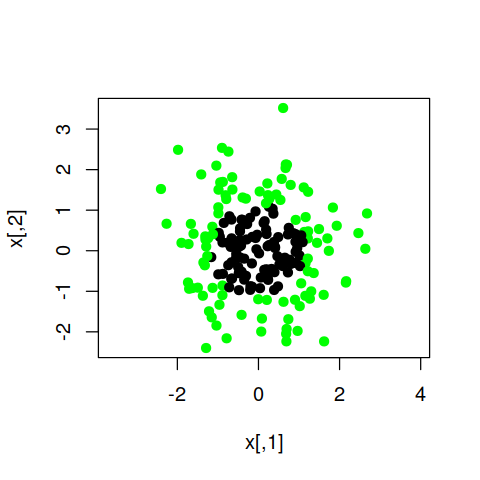

In [40]:
options(repr.plot.width=4, repr.plot.height=4)

set.seed(3)

p <- 2
N <- 200

x <- matrix(rnorm(N*p),ncol=p)
y <- as.numeric((x[,1]^2+x[,2]^2) > 1.4)
mydata <- data.frame(x=x,y=y)
plot(x,col=c('black','green')[y+1],pch=19,asp=1)

 Let's use one hidden layer, 3 hidden units, no regularization and the error function "cross-entropy"
 In this case it is not necessary to standardize because they variables already are
 (they have been generated from a distribution with mean 0 and standard deviation 1).

In [41]:
nn1 <- nnet(y~x.1+x.2,
            data=mydata,
            entropy=T,
            size=3,
            decay=0,
            maxit=2000,
            trace=F)

yhat <- as.numeric(predict(nn1,type='class'))

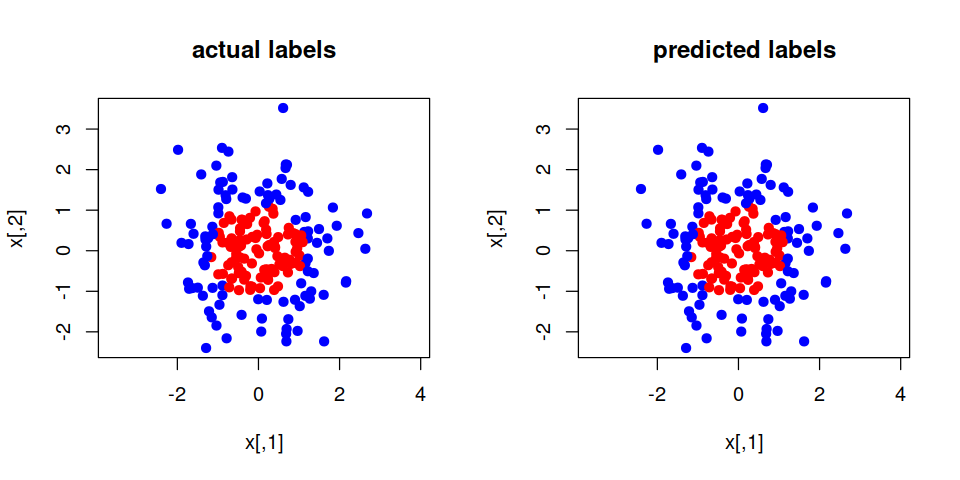

In [42]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(x,
     pch=19,
     col=c('red','blue')[y+1],
     main='actual labels',asp=1)
plot(x,col=c('red','blue')[(yhat>0.5)+1],
     pch=19,
     main='predicted labels',
     asp=1)

In [43]:
table(actual=y,predicted=predict(nn1,type='class'))

      predicted
actual   0   1
     0 100   0
     1   0 100

Excellent, indeed

 Let's execute it again, this time wth a different random seed

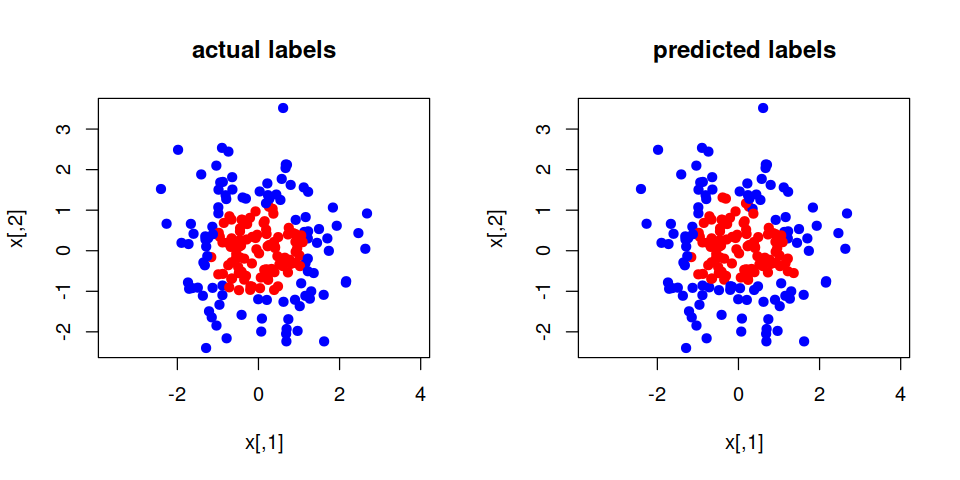

In [44]:
options(repr.plot.width=8, repr.plot.height=4)
set.seed(4)

nn1 <- nnet(y~x.1+x.2,
            data=mydata,
            entropy=T,
            size=3,
            decay=0,
            maxit=2000,
            trace=F)
yhat <- as.numeric(predict(nn1,type='class'))
par(mfrow=c(1,2))
plot(x,
     pch=19,
     col=c('red','blue')[y+1],
     main='actual labels',asp=1)
plot(x,
     col=c('red','blue')[(yhat>0.5)+1],
     pch=19,
     main='predicted labels',asp=1)

In [45]:
table(actual=y,predicted=predict(nn1,type='class'))

      predicted
actual  0  1
     0 91  9
     1  7 93

 we see that the optimizer does not always find a good solution, even with the right number of neurons

 How many hidden units do we need?

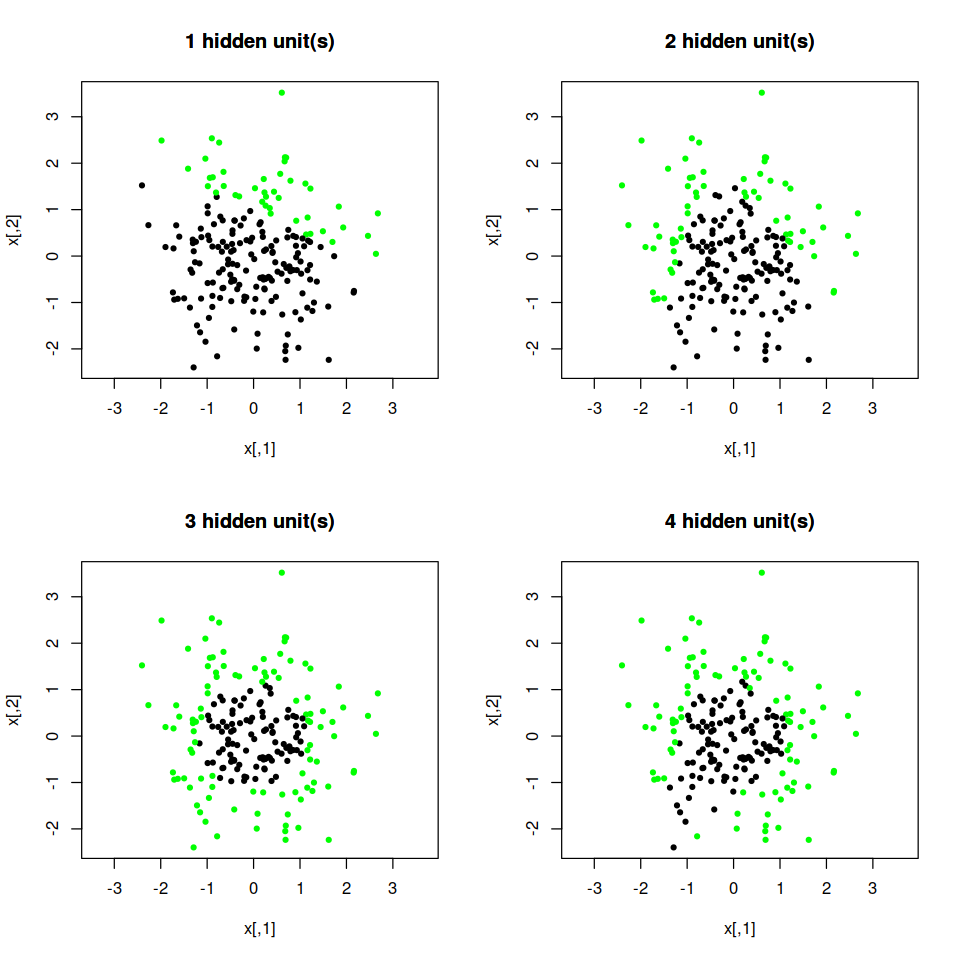

In [46]:
options(repr.plot.width=8, repr.plot.height=8)
par(mfrow=c(2,2))
for (i in 1:4)
{
  set.seed(3)
  nn1 <- nnet(y~x.1+x.2,
              data=mydata,
              entropy=T,
              size=i,
              decay=0,
              maxit=2000,
              trace=F)
  yhat <- as.numeric(predict(nn1,type='class'))
  plot(x,
       pch=20,
       col=c('black','green')[yhat+1],
       main=paste(i,'hidden unit(s)'),
       asp=1)
title(main=paste(i,'hidden unit(s)'))
}

 Let's find out which function has been learned exactly, with 3 units

In [47]:
set.seed(3)
nn1 <- nnet(y~x.1+x.2,
            data=mydata,
            entropy=T,
            size=3,
            decay=0,
            maxit=2000,
            trace=F)

create a grid of values

In [48]:
x1grid <- seq(-3,3,l=200)
x2grid <- seq(-3,3,l=220)
xg <- expand.grid(x1grid,x2grid)
xg <- as.matrix(cbind(1,xg))

input them to the hidden units, and get their outputs

In [49]:
h1 <- xg%*%matrix(coef(nn1)[1:3],ncol=1)
h2 <- xg%*%matrix(coef(nn1)[4:6],ncol=1)
h3 <- xg%*%matrix(coef(nn1)[7:9],ncol=1)

the hidden units compute the logistic() function, so we cut the output value at 0; we get a decision line

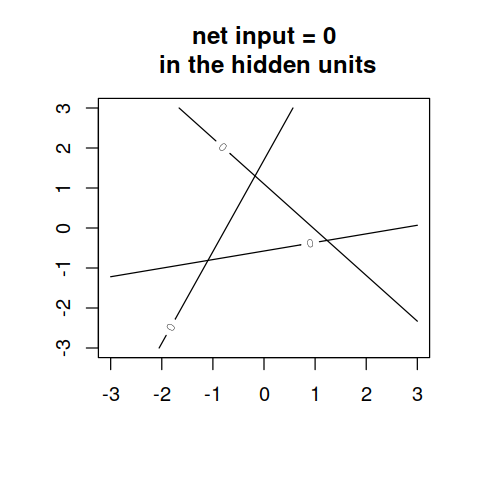

In [50]:
options(repr.plot.width=4, repr.plot.height=4)
par(mfrow=c(1,1))
contour(x1grid,x2grid,matrix(h1,200,220),levels=0)
contour(x1grid,x2grid,matrix(h2,200,220),levels=0,add=T)
contour(x1grid,x2grid,matrix(h3,200,220),levels=0,add=T)
title(main='net input = 0\n in the hidden units')

 this is the logistic function, used by nnet() for the hidden neurons, and 
 for the output neurons in two-class classification problems

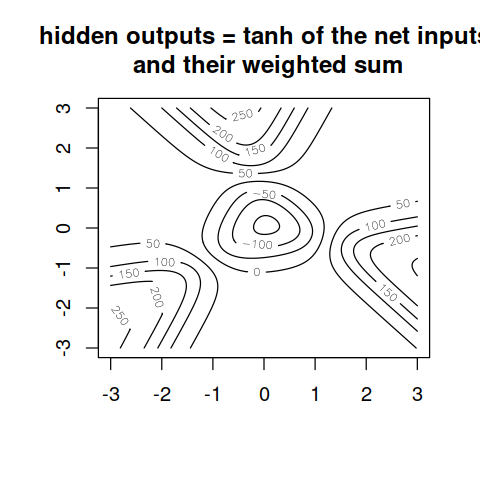

In [51]:

logistic <- function(x) {1/(1+exp(-x))}

z <- coef(nn1)[10] + coef(nn1)[11]*logistic(h1) + 
       coef(nn1)[12]*logistic(h2) + coef(nn1)[13]*logistic(h3)

contour(x1grid,x2grid,matrix(z,200,220))
title('hidden outputs = tanh of the net inputs\n and their weighted sum')

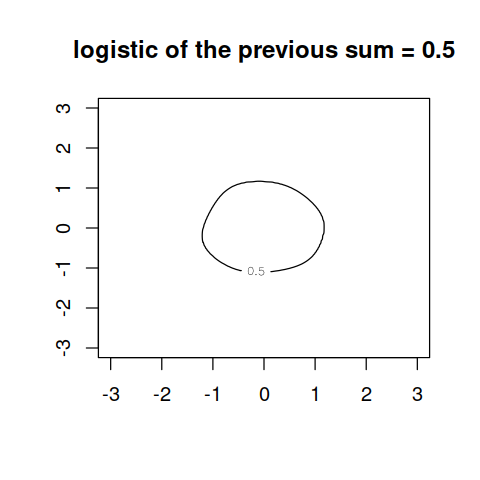

In [52]:

contour(x1grid,x2grid,matrix(logistic(z),200,220),levels=0.5)
title('logistic of the previous sum = 0.5')

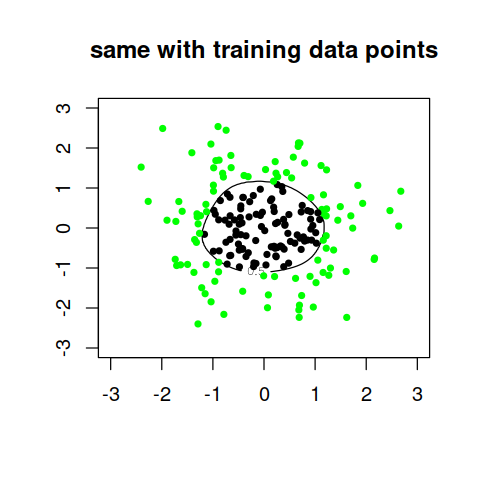

In [53]:

contour(x1grid,x2grid,matrix(logistic(z),200,220),levels=0.5)
points(x,pch=20,col=c('black','green')[y+1])
title('same with training data points')

 If you prefer a more visual demo of how ANN work, you can play with the Google's tensorflow playground http://playground.tensorflow.org

***

## Radial Basis Function Network Example: regression of a 1D function

In [54]:
set.seed (4)

library (cclust)

 We are going to do all the computations "by hand"

Let us depart from the following function in the (a,b) interval

In [55]:
myf <- function (x) { (1 + x - 2*x^2) * exp(-x^2) }

We are going to model this function in the interval (-5,5)

In [56]:
a <- -5
b <- 5

domain <- c(a,b)

myf.data <- function (N, a, b) 
{
  x <- runif(N, a, b)
  t <- myf(x) + rnorm(N, sd=0.2)
  dd <- data.frame(x,t)
  names(dd) <- c("x", "t")
  return (dd)
}

N <- 200
d <- myf.data (N, a , b)

summary(d)

       x                  t           
 Min.   :-4.97077   Min.   :-1.08566  
 1st Qu.:-2.36338   1st Qu.:-0.20412  
 Median : 0.04794   Median :-0.04610  
 Mean   : 0.14686   Mean   : 0.00188  
 3rd Qu.: 2.64938   3rd Qu.: 0.19471  
 Max.   : 4.96613   Max.   : 1.42546  

The black points are the data, the blue line is the true underlying function

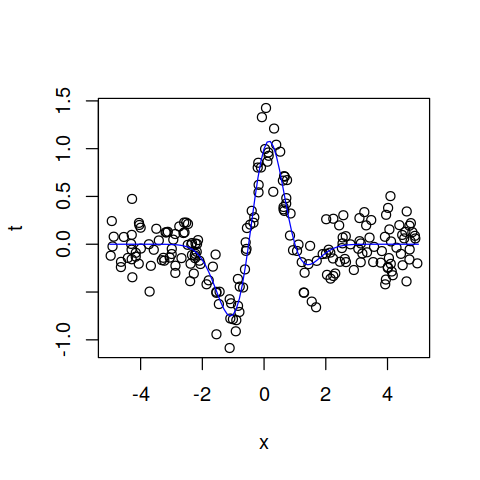

In [57]:
options(repr.plot.width=4, repr.plot.height=4)
plot (d)
curve (myf, a, b, col='blue', add=TRUE)

 Create a large test data too for future use; notice that the generation mechanism is the same

In [58]:
N.test <- 2000
d.test <- myf.data (N.test, a , b)

Function to compute a PHI (N x M) design matrix, without the Phi_0(x) = 1 column;
 m.i, h.i are the centers and variances (sigmas) of the neurons, respectively

In [59]:
PHI <- function (x,m.i,h.i)
{
  N <- length(x)
  M <- length(m.i)
  phis <- matrix(rep(0,(M)*N), nrow=M, ncol=N)
  for (i in 1:M)
  {
    phis[i,] <- exp(-(x - m.i[i])^2/(2*h.i[i]))
  }
  t(phis)
}

 We find the centers and variances for each neuron using k-means; since this clustering algorithm is non-deterministic (because the initial centers are random), we do it 'NumKmeans' times

In [60]:
NumKmeans <- 10

We set a rather large number of hidden units (= basis functions) M as a function of data size (the sqrt is just a heuristic!) because we are going to try different regularizers

In [61]:
(M <- floor(sqrt(N)))

m <- matrix(0,nrow=NumKmeans,ncol=M)
h <- matrix(0,nrow=NumKmeans,ncol=M)

data.Kmeans <- cbind(d$x,rep(0,N))

for (j in 1:NumKmeans)
{
  # Find the centers m.i with k-means
  km.res <- cclust (x=data.Kmeans, 
                    centers=M, 
                    iter.max=200, 
                    method="kmeans",
                    dist="euclidean")
  m[j,] <- km.res$centers[,1]
  
  # Obtain the variances h.i as a function of the m.i
  h[j,] <- rep(0,M)
  for (i in 1:M)
  {
    indexes <- which(km.res$cluster == i)
    h[j,i] <- sum(abs(d$x[indexes] - m[j,i]))/length(indexes)
    if (h[j,i] == 0) h[j,i] <- 1
  }
}


[1] 14

 Now for each k-means we get the hidden-to-output weights by solving a regularized
 least-squares problem (standard ridge regression), very much as we did in previous labs

The difference is that now we perform ridge regression on the PHI matrix (that is, on the new regressors given by the hidden neurons), not on the original inputs ...

 ... and find the best lambda with using GCV across all choices of basis functions (the NumKmeans clusterings)

In [62]:
(lambdes <- 10^seq(-3,1.5,by=0.1))

library(MASS) # we need it for lm.ridge

errors <- rep(0,NumKmeans)
bestLambdes <- rep(0,NumKmeans)

# For each k-means result
for (num in 1:NumKmeans)
{
  m.i <- m[num,]
  h.i <- h[num,]
  
  myPHI <- PHI (d$x,m.i,h.i)
  aux1 <- lm.ridge(d$t ~ myPHI, d, lambda = lambdes)
  my.lambda <- as.numeric(names(which.min(aux1$GCV)))
  
  aux2 <- lm.ridge(d$t ~ myPHI, d, lambda = my.lambda)
  
  errors[num] <- sqrt(aux2$GCV)
  bestLambdes[num] <- my.lambda
  
}

[1]  0.001000000  0.001258925  0.001584893  0.001995262  0.002511886
 [6]  0.003162278  0.003981072  0.005011872  0.006309573  0.007943282
[11]  0.010000000  0.012589254  0.015848932  0.019952623  0.025118864
[16]  0.031622777  0.039810717  0.050118723  0.063095734  0.079432823
[21]  0.100000000  0.125892541  0.158489319  0.199526231  0.251188643
[26]  0.316227766  0.398107171  0.501187234  0.630957344  0.794328235
[31]  1.000000000  1.258925412  1.584893192  1.995262315  2.511886432
[36]  3.162277660  3.981071706  5.011872336  6.309573445  7.943282347
[41] 10.000000000 12.589254118 15.848931925 19.952623150 25.118864315
[46] 31.622776602

 Now we obtain the best model among the tested ones

In [63]:
bestIndex <- which(errors == min(errors))
bestLambda <- bestLambdes[bestIndex]
m.i <- m[bestIndex,]
h.i <- h[bestIndex,]

 we see that this problem needs a lot of regularization! This makes sense if you take a look at how the data is generated (the previous plot): the noise level is very high relative to the signal

 We also see that the best lambda fluctuates (since the data changes  due to the clustering, but the order of magnitude is quite stable

In [64]:
bestLambdes

[1] 1.258925 6.309573 1.258925 5.011872 3.981072 5.011872 3.162278 7.943282
 [9] 6.309573 5.011872

 We now create the final model:

In [65]:
my.RBF <- lm.ridge(d$t ~ PHI (d$x,m.i,h.i), d, lambda = bestLambda)

these are the final hidden-to-output weights: note how small they are (here is where we regularize)

In [66]:
(w.i <- setNames(coef(my.RBF), paste0("w_", 0:M)))

w_0          w_1          w_2          w_3          w_4          w_5 
 0.024822089 -0.066345890  0.497416574 -0.346465504  0.129436666  0.011216327 
         w_6          w_7          w_8          w_9         w_10         w_11 
-0.106166435 -0.002125259 -0.441257658 -0.823893756 -0.110522033 -0.033808309 
        w_12         w_13         w_14 
 0.051417832 -0.114800176  0.979021984

 It remains to calculate the prediction on the test data

In [67]:
test.PHI <- cbind(rep(1,length(d.test$x)),PHI(d.test$x,m.i,h.i))
y <- test.PHI %*% w.i

 And now the normalized error of this prediction

In [68]:
(errorsTest <- sqrt(sum((d.test$t - y)^2)/((N.test-1)*var(d.test$t))))

[1] 0.5076818

 Much better if we plot everything

In [69]:
par(mfrow=c(1,1))

 Test data in black,  Red data are the predictions  and the blue line is the underlying function

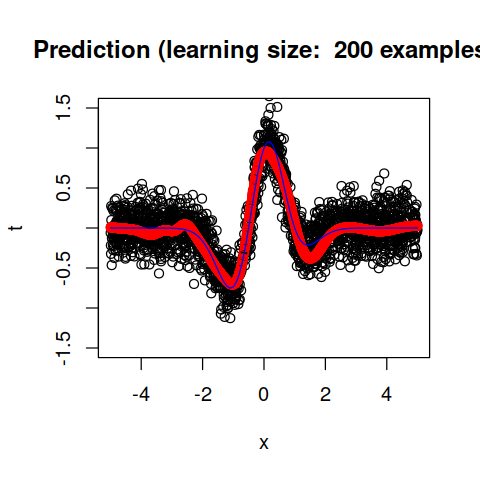

In [70]:
plot(d.test$x,d.test$t,
     xlab="x",ylab="t",
     main=paste("Prediction (learning size: ",toString(N),"examples)"),
     ylim=c(-1.5,1.5))

points(d.test$x,y,col='red',lwd=1)

curve (myf, a, b, col='blue', add=TRUE)


The previous code is designed for 1D problems but you can easily adapt it to more input dimensions

 There is a general package for neural networks: {RSNNS}

 Which is actually the R interface to the (formerly widely used and flexible) Stuttgart Neural Network Simulator (SNNS)

 This library contains many standard implementations of neural networks. The {RSNNS} package actually wraps the SNNS functionality to make it available from within R

The RBF version within this package has a sophisticated method for initializing the network, which is also quite non-standard, so we avoid further explanation

 Sadly this package does not provide with a way to control regularization or to allow for multi-class problems (a softmax option with the cross-entropy would be welcome)
 
